# Spark GraphFrames

#### by Brull Borràs, Pere Miquel

## Getting Ready

Ok so, this has been quite a journey, and please disregard the *Quick* in Quick-Start as it's taken a few hours just to get the copy-paste example to work. Thus, I'm gonna write some steps down before I forget.

While looking through github issues and StackOverflow, people were asking for separate problems, but here i present you the complete saga, also with one unfound error that personally I don't understand, but hey, it works.

<div class="alert alert-info">
Note: These are the issues found when installing and running graphframes in Windows. It is common knowledge that windows cmd is lacking when compared to Unix. To being able to use Unix commands, install GOW for Windows.
</div>

1. First of all, download Spark from this [link](https://spark.apache.org/downloads.html). I just got the fresh Spark 2.3. I have it placed inside ```C:\```, so I will be using it as path example. Remember to set all options and paths to be able to use Pyspark with Jupyter.
2. Now, download **graphframes** package from the Spark packages [site](https://spark-packages.org/package/graphframes/graphframes). 
3. Unzip it and check that you got the directory: ```\graphframes\python\graphframes```. Inside you should have the following structure:
```
graphframes
│   __init__.py
│   graphframe.py
│   tests.py 
│   
└─── examples
│ 
└─── lib
```
Copy this inside your the Spark directory: ```C:\Spark\spark-2.3.0-bin-hadoop2.7\python\pyspark```, where other modules like MLlib and Streaming are placed.

4. Once you are set, run: ```pyspark --packages graphframes:graphframes:0.5.0-spark2.1-s_2.11```. You should see something like this
```
        ---------------------------------------------------------------------
        |                  |            modules            ||   artifacts   |
        |       conf       | number| search|dwnlded|evicted|| number|dwnlded|
        ---------------------------------------------------------------------
        |      default     |   5   |   0   |   0   |   0   ||   5   |   0   |
        ---------------------------------------------------------------------
```
However, here is where I found the first weird error. Spark could not locate nor download ```org.slf4j#slf4j-api;1.7.7 from local-m2-cache```. A fix for this is to download ```slf4j-api-1.7.7``` and place it under ``` C:\Users\Usuario\.m2\repository\org\slf4j\slf4j-api\1.7.7 ```. Please note that it is looking for version 1.7.7. I tried with newer ones but same problem appeared.

5. With these steps now you should be able to **import graphframes** modules. Nevertheless, fun goes on. Maybe I broke something when preparing the new Spark version, but I got a metastore_db and hive related error when creating the vertices and edges DataFrames. So let's give some attention to Hadoop now:

    1. Download Apache Hadoop. I am using hadoop-2.7.1. Place it under ```C:\hadoop```.
    2. Set ```HADOOP_HOME=C:\hadoop``` and include ```%HADOOP_HOME%\bin``` to the PATH environment.
    3. Create ```C:\tmp\hive ``` directory and run: ```winutils.exe chmod -R 777 \tmp\hive ```.

6. Remember how we downloaded slf4j-api version 1.7.7? Well, now you should be able to create both DataFrames, but when creating the GraphFrame, it is going to fail, as it does not find logging classes related to: ```scala-logging-slf4j_2.10-2.1.2.jar```. Yes, version 2.1.2. Download both ```scala-logging-slf4j_2.10-2.1.2.jar``` and ```scala-logging-api_2.10-2.1.2.jar``` and place them under the jars directory inside Spark.

## Warmup

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql import Row
from graphframes import graphframe as GF

sc = SparkContext.getOrCreate()

For creating the graph, we first need to generate data for both vertices and edges in the form of DataFrames:

In [2]:
v = sqlContext.createDataFrame([("a", "Alice", 34), 
                                ("b", "Bob", 36),
                                ("c", "Charlie", 30),
                                ("d", "David", 29),
                                ("e", "Esther", 32),
                                ("f", "Fanny", 36),
                                ("g", "Gabby", 60)],
                               ["id", "name", "age"])
e = sqlContext.createDataFrame([("a", "b", "friend"),
                                ("b", "c", "follow"),
                                ("c", "b", "follow"),
                                ("f", "c", "follow"), 
                                ("e", "f", "follow"),
                                ("e", "d", "friend"),
                                ("d", "a", "friend"),
                                ("a", "e", "friend")], 
                                ["src", "dst", "relationship"])

Create the graph and show edges and vertices:

In [3]:
g = GF.GraphFrame(v, e)
print('Show graph edges:')
g.edges.show()
print('Show graph vertices:')
g.vertices.show()

Show graph edges:
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+

Show graph vertices:
+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



## Basic GrapFrames

### 1. Load the Graph

We need to load the data from text files, parse them and create the DataFrames for the edges and vertices. Then, form the Graph G.

In [4]:
peopleFile = sc.textFile("./Input/people.txt")
likesFile = sc.textFile("./Input/likes.txt")

peopleSchema = peopleFile.first()
likesSchema = likesFile.first()

people = peopleFile.filter(lambda l: l != peopleSchema)\
    .map(lambda l: l.split(','))
    
likes = likesFile.filter(lambda l: l != likesSchema)\
    .map(lambda l: l.split(','))
    
print('Schema for people (vertices) is: {}. For example: {}.'.format(peopleSchema, people.first()))
print('Schema for likes (edges) is: {}. For example {}.'.format(likesSchema, likes.first()))

Schema for people (vertices) is: id,name,age. For example: ['1', 'Alice', '28'].
Schema for likes (edges) is: src,dst,likes. For example ['2', '1', '7'].


In [5]:
row_data_people = people.map(lambda p: Row(
    id=int(p[0]), 
    name=str(p[1]),
    age=int(p[2])
    )
)

row_data_likes = likes.map(lambda p: Row(
    src=int(p[0]), 
    dst=int(p[1]),
    likes=int(p[2])
    )
)

people_df = sqlContext.createDataFrame(row_data_people)
likes_df = sqlContext.createDataFrame(row_data_likes)

G = GF.GraphFrame(people_df, likes_df)

### 2. Graph Views

Graph's edges and vertices are DataFrames that can be accessed (G.edges & G.vertices). Let's display the name of the users that are at least 30 years old:

In [7]:
print('G.vertices is a: {}. \n'.format(G.vertices))

# vertices30 is also a DF
vertices30 = G.vertices.select("name","age").filter(G.vertices.age > 30).orderBy("age", ascending=True)

# Collect and print:   
print(*('{} is {}.'.format(x.name, x.age) for x in vertices30.rdd.collect()), sep='\n')

G.vertices is a: DataFrame[age: bigint, id: bigint, name: string]. 

David is 42.
Fran is 50.
Ed is 55.
Charlie is 65.


**EdgeTriplets** is a class that extends the Edge class by adding the source and destination of the edge with their properties:

In [8]:
G.triplets.show()

+----------------+---------+----------------+
|             src|     edge|             dst|
+----------------+---------+----------------+
|     [55, 5, Ed]|[6, 3, 5]|   [50, 6, Fran]|
|[65, 3, Charlie]|[6, 3, 3]|   [50, 6, Fran]|
|    [27, 2, Bob]|[1, 7, 2]|  [28, 1, Alice]|
|  [42, 4, David]|[1, 1, 4]|  [28, 1, Alice]|
|     [55, 5, Ed]|[3, 8, 5]|[65, 3, Charlie]|
|     [55, 5, Ed]|[2, 2, 5]|    [27, 2, Bob]|
|[65, 3, Charlie]|[2, 4, 3]|    [27, 2, Bob]|
|    [27, 2, Bob]|[4, 2, 2]|  [42, 4, David]|
+----------------+---------+----------------+



Let's clean the new DataFrame to display the names of who likes who. First collect the triplets class and check how is structured the data we are going to work with:

In [9]:
triplet = G.triplets.collect()
print(triplet[0])

Row(src=Row(age=55, id=5, name='Ed'), edge=Row(dst=6, likes=3, src=5), dst=Row(age=50, id=6, name='Fran'))


We have a Row of Rows. Thus, we can access all the data with the following structure:
``` triplet[rowid][column_name][inner_column_name] ```, for example:

In [10]:
print(triplet[0]["src"]["name"])

Ed


In [11]:
# Key argument in sorted lets us sort by complex data structures:
print(*('{} likes {}.'.format(x["src"]["name"], x["dst"]["name"]) for x in 
        sorted(triplet, key=lambda l: l["src"]["name"])), sep='\n')

Bob likes Alice.
Bob likes David.
Charlie likes Fran.
Charlie likes Bob.
David likes Alice.
Ed likes Fran.
Ed likes Charlie.
Ed likes Bob.


Filter now by users with more than 5 likes:

In [12]:
triplet = G.triplets.filter(G.triplets["edge"]["likes"] > 5).collect()

print(*('{} loves {}.'.format(x["src"]["name"], x["dst"]["name"]) for x in 
        sorted(triplet, key=lambda l: l["src"]["name"])), sep='\n')

Bob loves Alice.
Ed loves Charlie.


### 3. Querying the Graph

* Find the youngest user's age in the graph.

In [13]:
min_age = G.vertices.select("age").agg({"age": "min"}).collect()[0][0]
min_age_row = G.vertices.select("name", "age").filter(G.vertices.age == min_age).collect()

print("The youngest user is {}, who is {} years old.".format(min_age_row[0]["name"], min_age))

The youngest user is Bob, who is 27 years old.


* For each user show the number of likes received and given.

In [14]:
# in/outDegrees gives us a DF with the vertex index and degree.
likesReceived = G.inDegrees
likesGiven = G.outDegrees

InOut = G.vertices.join(likesReceived, G.vertices["id"]==likesReceived["id"], "left").drop(likesReceived.id)\
                  .join(likesGiven, G.vertices["id"]==likesGiven["id"], "left").drop(likesGiven.id)\
                  .collect()
        


In [15]:
print(*('{} has given {} likes and received {}.'.format(x["name"], x["outDegree"], x["inDegree"]).replace("None",'0')
        for x in sorted(InOut, key=lambda l: l["name"])), sep='\n')

Alice has given 0 likes and received 2.
Bob has given 2 likes and received 2.
Charlie has given 2 likes and received 1.
David has given 1 likes and received 1.
Ed has given 3 likes and received 0.
Fran has given 0 likes and received 2.


### 4. Motif Finding

One of the most exciting aspects of working with Graphs is being able to query on the topography and get fast results, au contraire of relational databases that would require costly joins to get the same results.

It uses a Domain-Specific-Language (DSL) for expressing structural queries. For example:
* (a)-[e]->(b); (b)-[e2]->(c)

It would list all sets of 3 vertexs that are connected in the specified direction. Vertexs and edges names in the query are *aliases*, which are useful when concatenating queries:

* (a)-[e]->(b); (b)-[e2]->(a)

Now, we would get a cycle. Note that it is also possible to omit aliases when not needed.

**Examples**:
* Recommend who to follow, and triplets of users A,B,C where A follows B and B follows C, but A does not follow C.

In [16]:
motif1 = G.find("(a)-[e]->(b); (b)-[e2]->(c); !(a)-[]->(c)")

print(*('{} likes {}, and {} likes {}, so {} may like {}.'
        .format(x["a"]["name"], x["b"]["name"], x["b"]["name"], x["c"]["name"],
               x["a"]["name"], x["c"]["name"])
        for x in sorted(motif1.collect(), key=lambda l: l["a"]["name"])), sep='\n')

Charlie likes Bob, and Bob likes David, so Charlie may like David.
Charlie likes Bob, and Bob likes Alice, so Charlie may like Alice.
Ed likes Bob, and Bob likes David, so Ed may like David.
Ed likes Bob, and Bob likes Alice, so Ed may like Alice.


* Find the subgraph of people with 3 likes or more.

In [19]:
motif2 = G.find("(src)-[edge]->(dst)").filter("edge.likes >= 3")
motif2.show()

+----------------+---------+----------------+
|             src|     edge|             dst|
+----------------+---------+----------------+
|     [55, 5, Ed]|[6, 3, 5]|   [50, 6, Fran]|
|[65, 3, Charlie]|[6, 3, 3]|   [50, 6, Fran]|
|    [27, 2, Bob]|[1, 7, 2]|  [28, 1, Alice]|
|     [55, 5, Ed]|[3, 8, 5]|[65, 3, Charlie]|
|[65, 3, Charlie]|[2, 4, 3]|    [27, 2, Bob]|
+----------------+---------+----------------+



In [20]:
"""
Function for plotting a graph using networkx.
Input is a collected DataFrame triplet from graphframes.
"""
def plot_graph(df):
    Gplot = nx.Graph()
    Gplot.add_nodes_from(list(set([x["src"]["name"] for x in df]
             + [x["dst"]["name"] for x in df])))

    Gplot.add_edges_from([[x["src"]["name"], x["dst"]["name"]] 
                          for x in df])

    # All together we can do something fancy
    nx.draw(Gplot, with_labels=True, node_size=1500, node_color="skyblue", 
            node_shape="o", alpha=0.5, linewidths=4, font_size=20, 
            font_color="grey", font_weight="bold", 
            width=2, edge_color="grey")

We depart from the original graph:

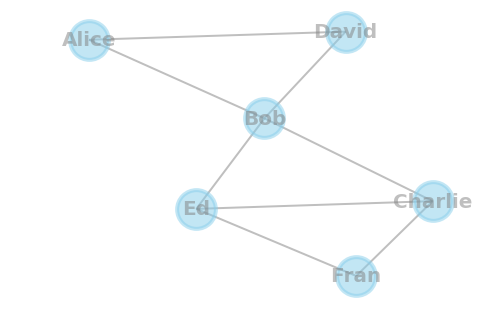

In [21]:
plot_graph(G.triplets.collect())

And we end up with the following subgraph:

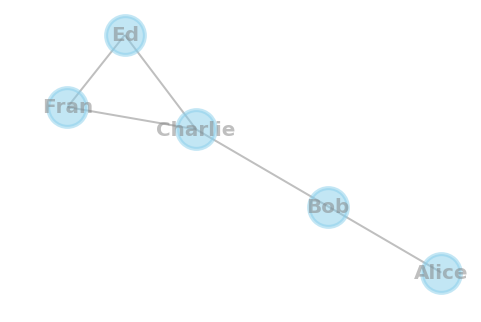

In [22]:
plot_graph(motif2.collect())

## Analyzing Wikipedia Articles Relevance

### 1. Load the Graph

This time there is no header to filter. There is just the id's and article's name.

In [23]:
articlesFile = sc.textFile("./Input/wiki-vertices.txt")
linksFile = sc.textFile("./Input/wiki-edges.txt")

articles = articlesFile.map(lambda l: l.split('\t'))
    
links = linksFile.map(lambda l: l.split('\t'))
    
print('Schema for articles (vertices) is: {}'.format(articles.first()))
print('Schema for links (edges) is: {}.'.format(links.first()))

Schema for articles (vertices) is: ['6598434222544540151', 'Adelaide Hanscom Leeson']
Schema for links (edges) is: ['36359329835505530', '6843358505416683693'].


In [24]:
row_data_article = articles.map(lambda p: Row(
    id=int(p[0]), 
    name=str(p[1])
    )
)

row_data_links = links.map(lambda p: Row(
    src=int(p[0]), 
    dst=int(p[1])
    )
)

article_df = sqlContext.createDataFrame(row_data_article)
links_df = sqlContext.createDataFrame(row_data_links)

W = GF.GraphFrame(article_df, links_df)

### 2. Entity Link Analysis

**PageRank** is one of the measures used by Google when listing web pages that indicates the web importance by accounting all the links refered to that specific page. Google paper citation:

> We assume page A has pages $T_1, \ldots , T_n$ which point to it (i.e., are citations). The parameter $d$ is a damping factor which can be set between 0 and 1. We usually set $d$ to 0.85. Also $C(A)$ is defined as the number of links going out of page A. The PageRank $PR$ of a page A is given as follows:

> $$PR(A) = (1 - d) + d \times (PR(T_1) / C(T_1) + \ldots + PR(T_n)/C(T_n)).$$

> Note that the PageRanks form a probability distribution over web pages, so the sum of all web pages' PageRanks will be one.
PageRank or $PR(A)$ can be calculated using a simple iterative algorithm, and corresponds to the principal eigenvector of the
normalized link matrix of the web.

> PageRank or $PR(A)$ can be calculated using a simple iterative
algorithm, and corresponds to the principal eigenvector of the
normalized link matrix of the web.

In [25]:
# Run PageRank until convergence to tolerance "tol".
results = W.pageRank(resetProbability=0.15, tol=0.01)
# Display resulting pageranks and final edge weights
# Note that the displayed pagerank may be truncated, e.g., missing the E notation.
# In Spark 1.5+, you can use show(truncate=False) to avoid truncation.
results.vertices.select("id", "pagerank").show()
results.edges.select("src", "dst", "weight").show()

+-------------------+-------------------+
|                 id|           pagerank|
+-------------------+-------------------+
|  60141164114404611|0.35702594230955786|
| 173684472086590769|0.35702594230955786|
| 176887352938142094|0.35702594230955786|
| 281122592442407249|0.35702594230955786|
| 301070397943306564| 0.6548282188378524|
| 507001091046844781|0.35702594230955786|
| 712072413066915002|0.35702594230955786|
| 940666254847084065|0.35702594230955786|
|1059768577358155574|0.35702594230955786|
|1085375068557587515|0.47966441699092444|
|1134911760014989030|  6.188192758269008|
|1187332656934037593| 0.5980959259702137|
|1263311176468471398|0.35702594230955786|
|1310035909053628152|0.35702594230955786|
|1324200442851109209| 0.3838608088908364|
|1367968407838934737| 0.8054606308586486|
|1388007610662316646|  5.729146760013646|
|1622966179930861379|0.35702594230955786|
|1627148279048617007| 0.4556676219590877|
|1674224868208988261| 0.3602322079213017|
+-------------------+-------------

For more information, find here the [User Guide](https://graphframes.github.io/user-guide.html).